[Probability and Statistics for Data Science](https://www.ps4ds.net/) 

Code for Figures 5.5 and 5.7, and Example 5.14

Analysis of hourly temperature data from 2015 in Manhattan (Kansas) and Versailles (Kentucky)\
Topics: Joint probability density function, marginal distribution, conditional distribution

Author: Carlos Fernandez-Granda\
Data source: https://www1.ncdc.noaa.gov/pub/data/uscrn/products/

In [37]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

font_size = 15
font_size_ticks = 15

np.set_printoptions(precision=3)

file_name_temperature_2015 = "../data/weather/temperatures_2015.npy"

data_matrix = np.load(file_name_temperature_2015)

file_name_list = np.load('../data/weather/weather_station_names.npy')

def process_name(x):
    x = x[14:]
    x = x[:-7]
    x = x.translate(str.maketrans('','','_1234567890'))
    return x[2:] + ", " + x[:2]

In [38]:
stations = [52,55] 
station_names = []
for station in stations:
    name = process_name(file_name_list[station])
    station_names.append(name)
    print(name) 

Manhattan, KS
Versailles, KY


In [39]:
def remove_faulty_measurements(data,verbose):
    min_val = -100 # We assume temperatures cannot be lower than -100
    for ind in range(len(data)):
        median = np.median(data[data > min_val])
        if data[ind] < min_val:
            if verbose:
                print(str(ind) + ": " + str(data[ind]))
            aux_ind = ind-1
            while aux_ind > 0:
                if data[aux_ind] > min_val:
                    data[ind] = data[aux_ind]
                    if verbose:
                        print("entry " + str(aux_ind) + " changed to " + str(data[ind]))
                    break
                else:
                    ind -= 1
    return data

verbose = False
temperature_1 = remove_faulty_measurements(data_matrix[:,stations[0]],verbose)
temperature_2 = remove_faulty_measurements(data_matrix[:,stations[1]],verbose)

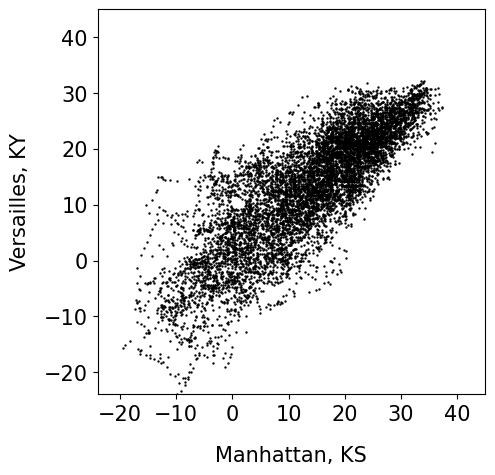

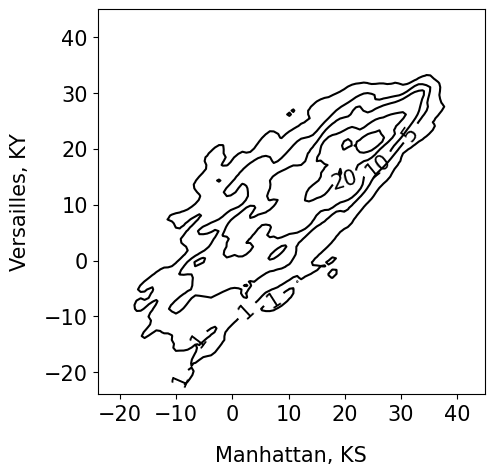

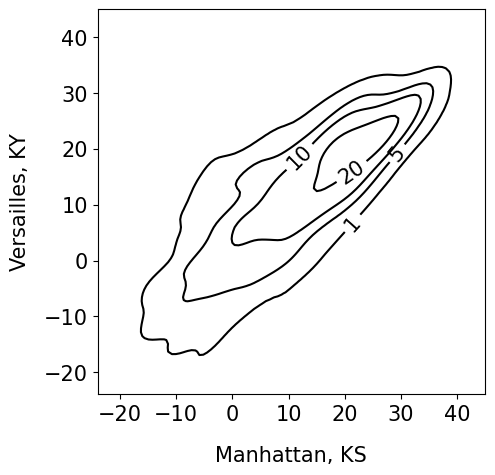

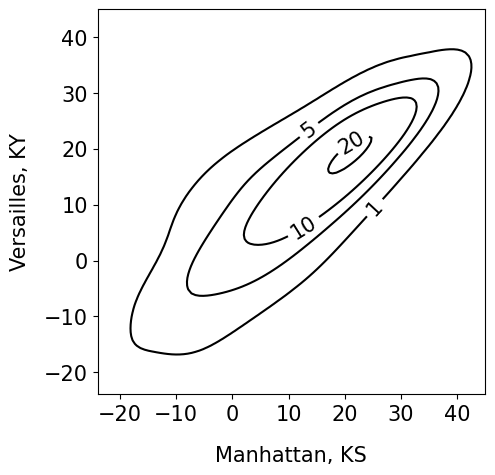

In [40]:
def KDE_2D(data_1,data_2,x,y,bw=None):
    grid = np.vstack([x.ravel(), y.ravel()])
    values = np.vstack([data_1, data_2])
    kernel = stats.gaussian_kde(values,bw_method=bw)
    kde = np.reshape(kernel(grid).T, x.shape)
    return kde

def fmt(x):
    s = f"{x:.4f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"

xmin = -24
xmax = 45
ymin = -24
ymax = 45
x_2D,y_2D = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    
markersize = 0.5 
plt.figure(figsize=(5,5))
plt.scatter(temperature_1,temperature_2,s=markersize,color="black",rasterized=True)
plt.xticks(fontsize=font_size_ticks) 
plt.yticks(fontsize=font_size_ticks)
plt.ylim([ymin,ymax])
plt.xlim([xmin,xmax])
plt.ylabel(station_names[1],fontsize=font_size,labelpad = 10)
plt.xlabel(station_names[0],fontsize=font_size,labelpad = 15)

# Bandwidth parameter for kernel density estimation
bw_vals = [0.1,0.25,0.5]

levels = [1,5,10,20,30]

for ind,bw in enumerate(bw_vals):
    kde = KDE_2D(temperature_1,temperature_2,x_2D,y_2D,bw=bw)
    plt.figure(figsize=(5,5))
    CS = plt.contour(x_2D,y_2D, 1e4*kde, levels=levels,colors='black')
    plt.clabel(CS, CS.levels, inline=True, fmt=fmt,fontsize=font_size_ticks)
    plt.xticks(fontsize=font_size_ticks) 
    plt.yticks(fontsize=font_size_ticks)
    plt.ylim([ymin,ymax])
    plt.xlim([xmin,xmax])
    plt.ylabel(station_names[1],fontsize=font_size,labelpad = 10)
    plt.xlabel(station_names[0],fontsize=font_size,labelpad = 15)

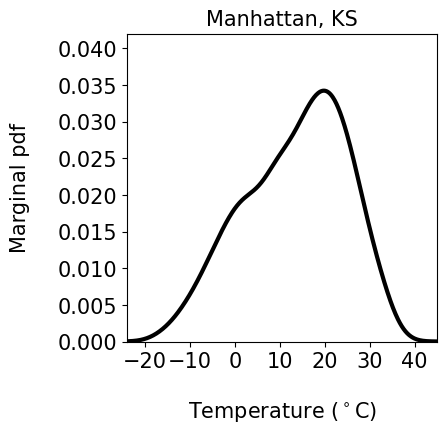

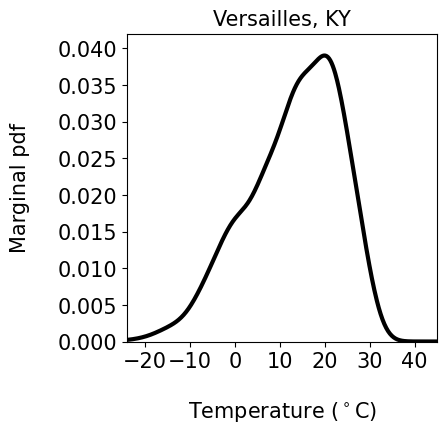

In [41]:
# Marginal distributions
x = np.linspace(xmin,xmax,500)
y_max_2 = 0.125
y_max_1 = 0.042

def KDE_1D(data,x,bw=None):
    kernel = stats.gaussian_kde(data,bw_method=bw)
    kde = kernel(x)
    return kde

bw_vals_1d = [bw_vals[1]] # We set the bandwidth to the intermediate value
for index,bw in enumerate(bw_vals_1d):
    kde = KDE_1D(temperature_1,x,bw=bw)
    plt.figure(figsize=(4,4))
    plt.xticks(fontsize=font_size_ticks) 
    plt.yticks(fontsize=font_size_ticks)
    plt.plot(x,kde,color="black",lw=3)
    plt.xlim([xmin,xmax])
    plt.ylim([0,y_max_1])
    plt.ylabel(r"Marginal pdf",fontsize=font_size,labelpad=20)
    plt.xlabel('Temperature ($^\circ$C)',fontsize=font_size,labelpad=20)
    plt.title(station_names[0],fontsize=font_size)
    
    kde = KDE_1D(temperature_2,x,bw=bw)
    plt.figure(figsize=(4,4))
    plt.xticks(fontsize=font_size_ticks) 
    plt.yticks(fontsize=font_size_ticks)
    plt.plot(x,kde,color="black",lw=3)
    #sns.kdeplot(temperature_2,bw=bw,color="black",lw=3,gridsize=1000, legend = False)#,color='white', edgecolor='black',linewidth=2)
    plt.xlim([xmin,xmax])
    plt.ylim([0,y_max_1])
    plt.ylabel(r"Marginal pdf",fontsize=font_size,labelpad=20)
    plt.xlabel('Temperature ($^\circ$C)',fontsize=font_size,labelpad=20)
    plt.title(station_names[1],fontsize=font_size)

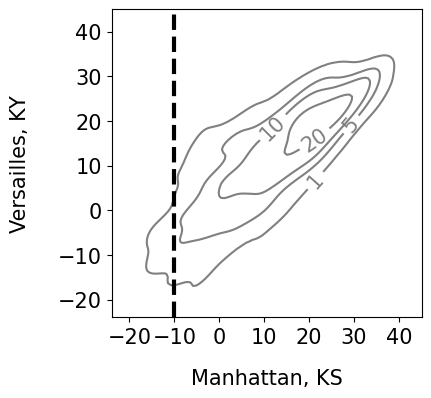

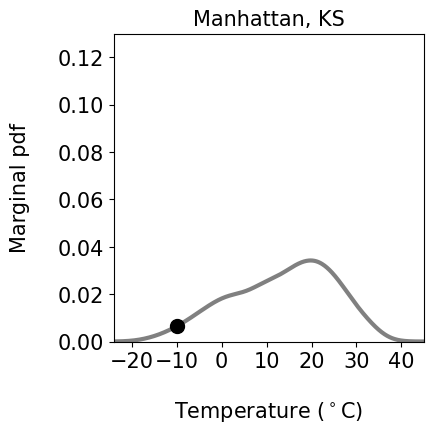

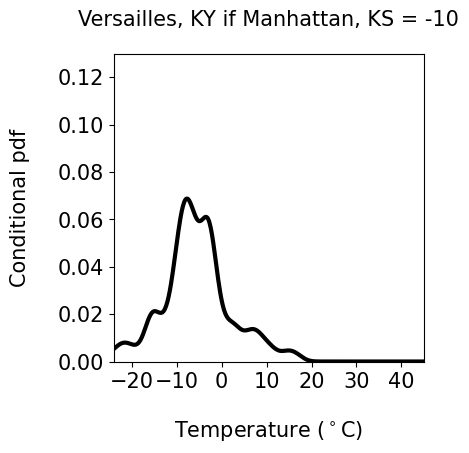

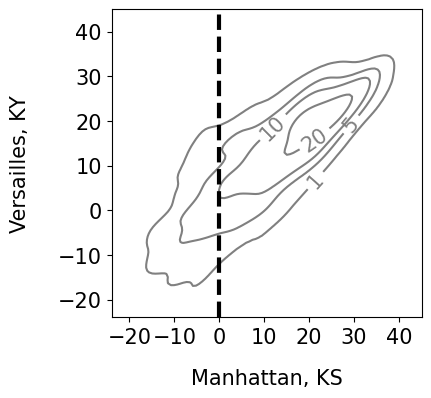

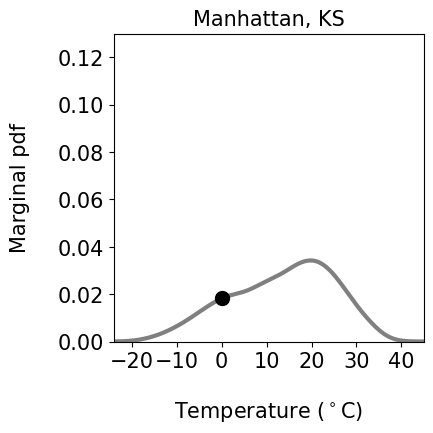

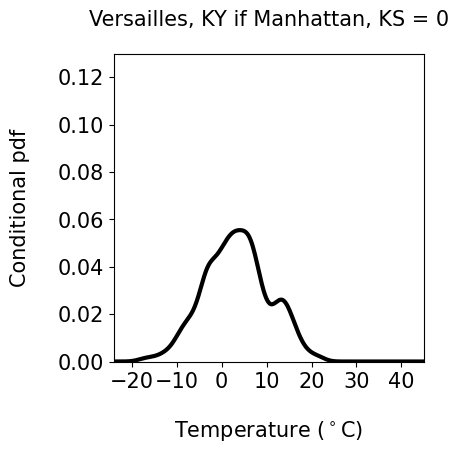

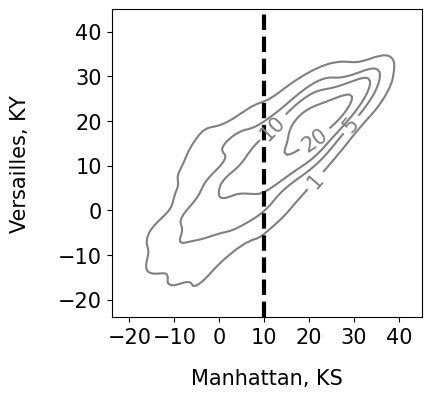

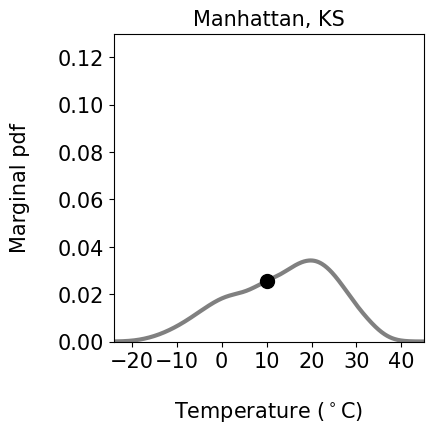

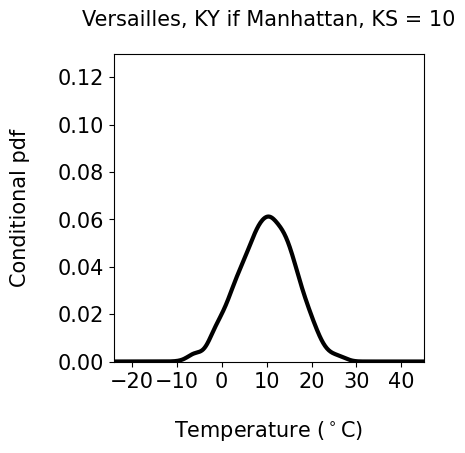

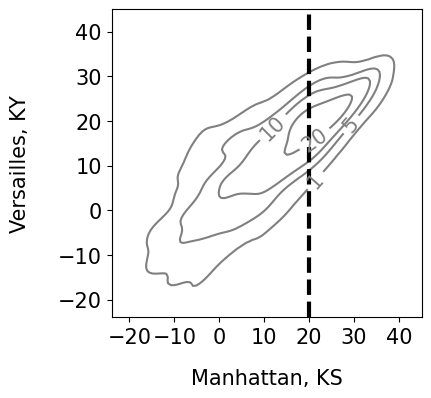

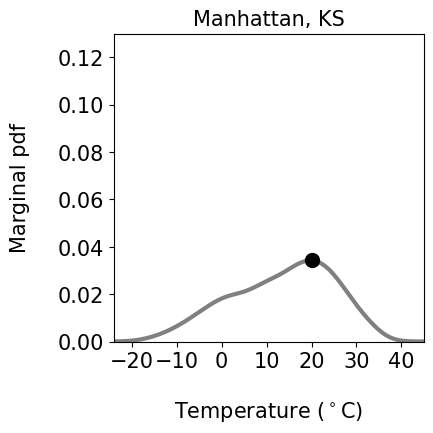

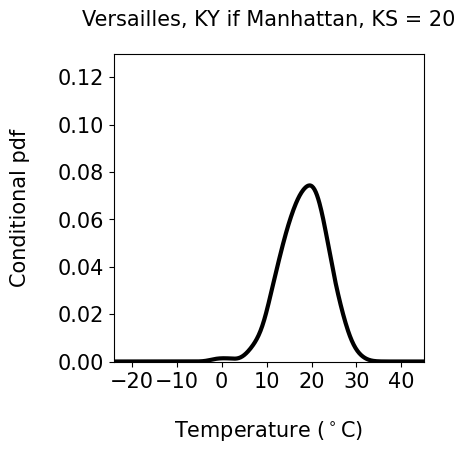

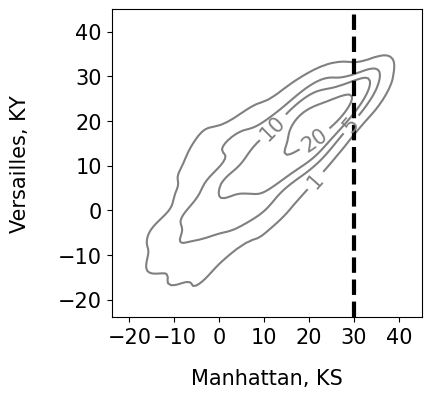

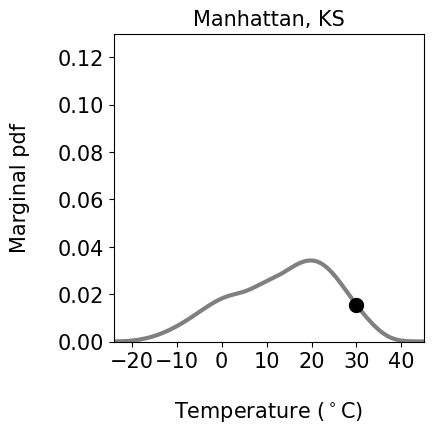

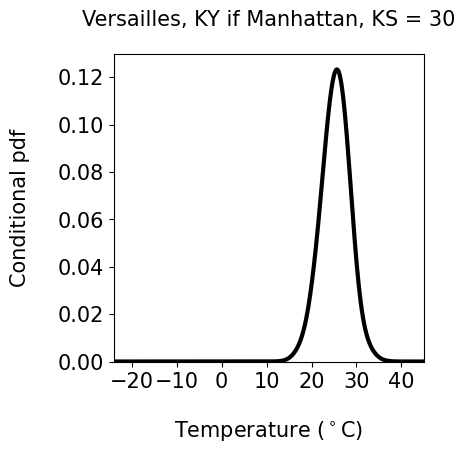

In [42]:
# Conditional distributions computed from the 2D density estimate

def KDE_cond(data,data_cond,val_cond,t,bw_1D=None,bw_2D=None,verbose=False):
    xmin = data.min()
    xmax = data.max()
    x,y = np.meshgrid(t,val_cond)
    grid = np.vstack([x.ravel(), y.ravel()])
    if verbose:
        print("Grid:")
        print(grid)
    values = np.vstack([data, data_cond])
    kernel_2D = stats.gaussian_kde(values,bw_method=bw_2D)
    kde_2D = np.reshape(kernel_2D(grid).T, x.shape)
    if verbose:
        print("kde_2D: ")
        print(kde_2D)
    kernel_1D = stats.gaussian_kde(data_cond,bw_method=bw)
    kde_1D = kernel_1D(val_cond)
    if verbose:
        print("kde_1D: ")
        print(kde_1D)
    kde_cond = kde_2D / kde_1D
    return kde_cond[0]

bw = 0.25
verbose = False
t_cond = [-10,0,10,20,30]
y_max_1 = 0.13

levels = [1,5,10,20,30]
for ind,t_val in enumerate(t_cond):
    
    kde = KDE_2D(temperature_1,temperature_2,x_2D,y_2D,bw=bw)
    plt.figure(figsize=(4,4))
    CS = plt.contour(x_2D, y_2D, 1e4*kde, levels=levels,colors='gray')
    plt.clabel(CS, CS.levels, inline=True, fmt=fmt,fontsize=font_size_ticks)
    plt.vlines(t_val,ymin,ymax,lw=3,ls="dashed",color="black")
    plt.xticks(fontsize=font_size_ticks) 
    plt.yticks(fontsize=font_size_ticks)
    plt.ylim([ymin,ymax])
    plt.xlim([xmin,xmax])
    plt.ylabel(station_names[1],fontsize=font_size,labelpad = 20)
    plt.xlabel(station_names[0],fontsize=font_size,labelpad = 15)
     
    kde = KDE_1D(temperature_1,x,bw=bw)
    plt.figure(figsize=(4,4))
    plt.xticks(fontsize=font_size_ticks) 
    plt.yticks(fontsize=font_size_ticks)
    plt.plot(x,kde,color="gray",lw=3)
    kernel_1D_manhattan = stats.gaussian_kde(temperature_1,bw_method=bw)
    plt.plot(t_val,kernel_1D_manhattan(t_val),'o',color="black",markersize=10)
    #sns.kdeplot(temperature_2,bw=bw,color="black",lw=3,gridsize=1000, legend = False)#,color='white', edgecolor='black',linewidth=2)
    plt.xlim([xmin,xmax])
    plt.ylim([0,y_max_1])
    plt.ylabel(r"Marginal pdf",fontsize=font_size,labelpad=20)
    plt.xlabel('Temperature ($^\circ$C)',fontsize=font_size,labelpad=20)
    plt.title(station_names[0],fontsize=font_size)
     
    kde = KDE_cond(temperature_2,temperature_1,t_val,x,bw_1D=bw,bw_2D=bw,verbose=verbose)
    plt.figure(figsize=(4,4))
    plt.xticks(fontsize=font_size_ticks) 
    plt.yticks(fontsize=font_size_ticks)
    plt.plot(x,kde,color="black",lw=3)
    plt.xlim([xmin,xmax])
    plt.ylim([0,y_max_1])
    plt.ylabel(r"Conditional pdf",fontsize=font_size,labelpad=20)
    plt.xlabel('Temperature ($^\circ$C)',fontsize=font_size,labelpad=20)
    plt.title(station_names[1] + " if " +station_names[0] + " = " + str(t_val),fontsize=font_size_ticks,pad = 20)